In [1]:
# Geographic Information Retrieval and Integration: Assessment 1
# Using psuedo-Zoopla property data

In [2]:
# setting working directory
%cd "/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Information Retrieval/Assessment1"

C:\Users\lewil\OneDrive - University of Bristol\Msc Geographic Data Science & Spatial Analytics\Information Retrieval\Assessment1


In [3]:
# loading required packages
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import fiona # for reading in subset of shapefile
from shapely.geometry import MultiPolygon # for polygon grouping
import matplotlib.pyplot as plt # for plotting

In [24]:
# Read in psuedo_Zoopla GeoJSON with geopandas
psuedo_zoopla = gpd.read_file("pseudo_zoopla.geojson")

# Dropping Index column (python adds one automatically) 
psuedo_zoopla = psuedo_zoopla.drop(columns=['ID'])

# setting "date" as date format
psuedo_zoopla['date'] = pd.to_datetime(psuedo_zoopla['date'])
# setting 'num_rooms' and 'num_baths' as integers to save memory
psuedo_zoopla['num_rooms'] = psuedo_zoopla['num_rooms'].astype('Int64') 
psuedo_zoopla['num_baths'] = psuedo_zoopla['num_baths'].astype('Int64')

# ordering by date
psuedo_zoopla = psuedo_zoopla.sort_values(by='date', ascending=False)
# checking structure
print(psuedo_zoopla.head())
psuedo_zoopla.shape

       Price  num_rooms  num_baths       date                   geometry
318  1033062          2          1 2019-12-31  POINT (-0.12198 51.52419)
540  1427501          4          1 2019-12-19  POINT (-0.10942 51.51141)
394  1305917          3          2 2019-12-16  POINT (-0.10761 51.50173)
797  1146673          3          4 2019-12-15  POINT (-0.12851 51.50423)
229   645665          3          3 2019-12-13  POINT (-0.13226 51.51153)


(1000, 5)

In [5]:
# reading in interest rate csv
InterestRates = pd.read_csv("InterestRate.csv")

# setting "Date Changed" as date format
InterestRates['Date Changed'] = pd.to_datetime(InterestRates['Date Changed'])
# renaming column to match psuedo_zoopla
InterestRates = InterestRates.rename(columns={'Date Changed': 'date'})
# sort by date
InterestRates = InterestRates.sort_values(by='date', ascending=False)

# checking structure
print(InterestRates.head())
print(InterestRates.shape)
print(type(InterestRates))

        date  Rate
0 2023-08-03  5.25
1 2023-06-22  5.00
2 2023-05-11  4.50
3 2023-03-23  4.25
4 2023-02-02  4.00
(252, 2)
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Setting interest rates (vectorised approach using NumPy for compuational efficiency)
# utilising data being ranked by dates to avoid loops
psuedo_zoopla['closest_prior_idx'] = len(InterestRates) - np.searchsorted(InterestRates['date'].values[::-1], 
                                                                          psuedo_zoopla['date'].values, side='right')
# Extracting rates using the indices
psuedo_zoopla['Rate'] = InterestRates.loc[psuedo_zoopla['closest_prior_idx'], 'Rate'].values

# checking output
print(psuedo_zoopla.head())

       Price  num_rooms  num_baths       date                   geometry  \
318  1033062          2          1 2019-12-31  POINT (-0.12198 51.52419)   
540  1427501          4          1 2019-12-19  POINT (-0.10942 51.51141)   
394  1305917          3          2 2019-12-16  POINT (-0.10761 51.50173)   
797  1146673          3          4 2019-12-15  POINT (-0.12851 51.50423)   
229   645665          3          3 2019-12-13  POINT (-0.13226 51.51153)   

     closest_prior_idx  Rate  
318                 16  0.75  
540                 16  0.75  
394                 16  0.75  
797                 16  0.75  
229                 16  0.75  


In [7]:
# Reading in polygon data for councils 
# setting file path
shapefile_path = 'C:/Users/lewil/OneDrive - University of Bristol/Msc Geographic Data Science & Spatial Analytics/Dissertation/Data/LondonOutputAreas/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp'

# using fiona to only read in required columns to save memory (column names from metadata)
with fiona.open(shapefile_path, 'r') as src:
    selected_schema = {'geometry': src.schema['geometry'], 'properties': {'LAD11NM': 'str', 'LAD11CD': 'str'}}

    # Read only the "geometry", "LAD11NM", and "LAD11CD" columns
    selected_cols = [{'properties': {'LAD11NM': feature['properties']['LAD11NM'], 'LAD11CD': feature['properties']['LAD11CD']}, 'geometry': feature['geometry']} for feature in src]

# Converting to a GeoDataFrame
LAD_polygons = gpd.GeoDataFrame.from_features(selected_cols, crs=src.crs)

# Checking structure
print(LAD_polygons.head())
LAD_polygons.shape

                                            geometry     LAD11NM    LAD11CD
0  POLYGON ((527635.452 171810.058, 527495.957 17...  Wandsworth  E09000032
1  POLYGON ((543581.516 171132.486, 543704.000 17...     Bromley  E09000006
2  POLYGON ((526613.539 171839.165, 526546.840 17...  Wandsworth  E09000032
3  POLYGON ((533563.521 179695.146, 533351.118 17...   Southwark  E09000028
4  POLYGON ((527822.000 172020.000, 527979.000 17...  Wandsworth  E09000032


(25053, 3)

In [8]:
# making grouped polygons for Local Authority Districts (LADs) instead of Output Areas (OA)

# Grouping geometries in LAD_polygons by 'LAD11CD' and aggregating the 'geometry' column
grouped_polygons = LAD_polygons.groupby('LAD11CD')['geometry'].agg(lambda x: x.unary_union)

# Creating a GeoDataFrame from the grouped polygons
LAD_polygon_df = gpd.GeoDataFrame(geometry=grouped_polygons.values, index=grouped_polygons.index, crs="EPSG:27700")

# Adding 'LAD11NM' column to LAD_polygon_df
LAD_polygon_df['LAD11NM'] = LAD_polygons.groupby('LAD11CD')['LAD11NM'].first().values

# Resetting index to have 'LAD11CD' as a column
LAD_polygon_df = LAD_polygon_df.reset_index()

# Printing GeoDataFrame
print(LAD_polygon_df.head())
LAD_polygon_df.shape

     LAD11CD                                           geometry  \
0  E09000001  MULTIPOLYGON (((531626.675 180538.983, 531667....   
1  E09000002  MULTIPOLYGON (((544448.182 183040.246, 544424....   
2  E09000003  POLYGON ((519605.675 191119.831, 519560.002 19...   
3  E09000004  MULTIPOLYGON (((544880.245 172189.452, 544619....   
4  E09000005  POLYGON ((516416.898 185147.598, 516179.054 18...   

                LAD11NM  
0        City of London  
1  Barking and Dagenham  
2                Barnet  
3                Bexley  
4                 Brent  


(33, 3)

In [9]:
# CRS is different so setting LAD_polygon_df CRS to psuedo_zoopla CRS
LAD_polygon_df = LAD_polygon_df.to_crs(psuedo_zoopla.crs)
# checking this has worked
LAD_polygon_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# assign point data in psuedo_zoopla a council (LAD)
joined_zoopla = gpd.sjoin(psuedo_zoopla, LAD_polygon_df, how="left", predicate="within")

# checking output
print(joined_zoopla.head())
joined_zoopla.columns.tolist()

       Price  num_rooms  num_baths       date                   geometry  \
318  1033062          2          1 2019-12-31  POINT (-0.12198 51.52419)   
540  1427501          4          1 2019-12-19  POINT (-0.10942 51.51141)   
394  1305917          3          2 2019-12-16  POINT (-0.10761 51.50173)   
797  1146673          3          4 2019-12-15  POINT (-0.12851 51.50423)   
229   645665          3          3 2019-12-13  POINT (-0.13226 51.51153)   

     closest_prior_idx  Rate  index_right    LAD11CD         LAD11NM  
318                 16  0.75          6.0  E09000007          Camden  
540                 16  0.75          0.0  E09000001  City of London  
394                 16  0.75         21.0  E09000022         Lambeth  
797                 16  0.75         32.0  E09000033     Westminster  
229                 16  0.75         32.0  E09000033     Westminster  


['Price',
 'num_rooms',
 'num_baths',
 'date',
 'geometry',
 'closest_prior_idx',
 'Rate',
 'index_right',
 'LAD11CD',
 'LAD11NM']

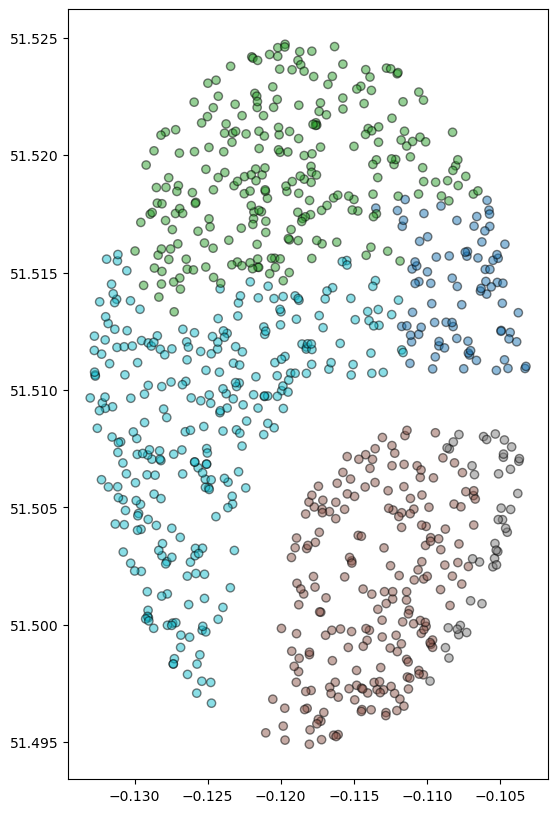

In [11]:
# plotting to see geometries are correct
ax = joined_zoopla.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', column='LAD11CD')

# Show the plot
plt.show()
# removes the points that aren't in an LAD11CD (in the river).

In [12]:
# count of NAs (points in the river).
joined_zoopla['LAD11CD'].isna().sum()

129

In [13]:
# removing rows without a LAD11CD
joined_zoopla = joined_zoopla.dropna(subset=['LAD11CD'])
joined_zoopla.shape # 129 rows have been dropped

(871, 10)

In [14]:
# read in tax bands csv
TaxBands = pd.read_csv("TaxBands.csv")
print(TaxBands)

  Council tax band Ranges of value (GBP)
0                A               <40,000
1                B         40,000-52,000
2                C         52,000-68,000
3                D         68,000-88,000
4                E        88,000-120,000
5                F       120,000-160,000
6                G       160,000-320,000
7                H              >320,000


In [15]:
# making array of bands 
bands = np.array([0, 40000, 52000, 68000, 88000, 120000, 160000, 320000, np.inf])

# adjusting bands for inflation (1991 to 2019)
inflated_bands = bands * 2.1483

# checking output
print(inflated_bands)

[     0.   85932.  111711.6 146084.4 189050.4 257796.  343728.  687456.
      inf]


In [16]:
# making band labels
band_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [17]:
# now assigning tax bands (A-H) on inflated_bands for psuedo_zoopla
joined_zoopla['TaxBand'] = pd.cut(joined_zoopla['Price'], bins=inflated_bands, labels=band_labels, right=False)

# checking output
print(joined_zoopla.head())

       Price  num_rooms  num_baths       date                   geometry  \
318  1033062          2          1 2019-12-31  POINT (-0.12198 51.52419)   
540  1427501          4          1 2019-12-19  POINT (-0.10942 51.51141)   
394  1305917          3          2 2019-12-16  POINT (-0.10761 51.50173)   
797  1146673          3          4 2019-12-15  POINT (-0.12851 51.50423)   
229   645665          3          3 2019-12-13  POINT (-0.13226 51.51153)   

     closest_prior_idx  Rate  index_right    LAD11CD         LAD11NM TaxBand  
318                 16  0.75          6.0  E09000007          Camden       H  
540                 16  0.75          0.0  E09000001  City of London       H  
394                 16  0.75         21.0  E09000022         Lambeth       H  
797                 16  0.75         32.0  E09000033     Westminster       H  
229                 16  0.75         32.0  E09000033     Westminster       G  


C:\Anaconda\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
# Reading in costs per band per LAD data
LADTaxRatesperBand = pd.read_csv("LADTaxRatesperBand.csv")
print(LADTaxRatesperBand.head())
# doesn't contain LAD codes. 
# eg difference "Hammersmith & Fulham" vs "Hammersmith and Fulham"

                    LAD       A        B        C        D        E        F  \
0           Westminster  502.56   586.33   670.09   753.85   921.37  1088.90   
1            Wandsworth  509.33   594.29   679.19   764.09   933.89  1103.69   
2  Hammersmith & Fulham  721.68   841.97   962.25  1082.53  1323.09  1563.66   
3  Kensington & Chelsea  793.70   925.99  1058.27  1190.55  1455.11  1719.68   
4                Newham  887.59  1035.53  1183.46  1331.38  1627.25  1923.11   

         G        H  
0  1256.41  1507.70  
1  1273.48  1528.18  
2  1804.21  2165.06  
3  1984.25  2381.10  
4  2218.98  2662.78  


In [19]:
# melting dataframe so that it is 'tidy' (unfortunatly creates repetition)
melted_LADTaxRatesperBand = pd.melt(LADTaxRatesperBand, id_vars=['LAD'], 
                                    var_name='TaxBand', 
                                    value_name='Cost')
print(melted_LADTaxRatesperBand)
# repetition acceptatble since data is small and finite: not dependant on number of properties.

                      LAD TaxBand     Cost
0             Westminster       A   502.56
1              Wandsworth       A   509.33
2    Hammersmith & Fulham       A   721.68
3    Kensington & Chelsea       A   793.70
4                  Newham       A   887.59
..                    ...     ...      ...
251               Croydon       H  3433.64
252              Havering       H  3457.32
253                Harrow       H  3569.60
254  Richmond upon Thames       H  3607.44
255  Kingston upon Thames       H  3801.70

[256 rows x 3 columns]


In [20]:
# assigning council tax costs to each property
# merging melted_LADTaxRatesperBand LAD with LAD_polygon_df LAD11NM 
# doing this by first words to mitigate ambiguity
melted_LADTaxRatesperBand['key'] = melted_LADTaxRatesperBand['LAD'].str.split().str[0]
joined_zoopla['key'] = joined_zoopla['LAD11NM'].str.split().str[0]
final_zoopla = pd.merge(joined_zoopla, melted_LADTaxRatesperBand, how='left', on=['key', 'TaxBand'])

# dropping surplus columns
final_zoopla.drop(columns=['key','LAD11NM','closest_prior_idx','index_right'], 
                  inplace=True) # inplace to save making an additional dataframe

In [21]:
# checking output
print(final_zoopla.head())
final_zoopla.isna().any(), final_zoopla.shape
# creates NaNs - there is no Ciy of London (or equivilent) in melted_LADTaxRatesperBand
# NaNs create issues for modelling, output is meant to be readily usable

     Price  num_rooms  num_baths       date                   geometry  Rate  \
0  1033062          2          1 2019-12-31  POINT (-0.12198 51.52419)  0.75   
1  1427501          4          1 2019-12-19  POINT (-0.10942 51.51141)  0.75   
2  1305917          3          2 2019-12-16  POINT (-0.10761 51.50173)  0.75   
3  1146673          3          4 2019-12-15  POINT (-0.12851 51.50423)  0.75   
4   645665          3          3 2019-12-13  POINT (-0.13226 51.51153)  0.75   

     LAD11CD TaxBand          LAD     Cost  
0  E09000007       H       Camden  3124.70  
1  E09000001       H          NaN      NaN  
2  E09000022       H      Lambeth  2890.39  
3  E09000033       H  Westminster  1507.70  
4  E09000033       G  Westminster  1256.41  


(Price        False
 num_rooms    False
 num_baths    False
 date         False
 geometry     False
 Rate         False
 LAD11CD      False
 TaxBand      False
 LAD           True
 Cost          True
 dtype: bool,
 (871, 10))

In [22]:
# dropping NaNs
final_zoopla.dropna(inplace=True) # inplace to save making an additional dataframe
# checking this has worked
final_zoopla.isna().any(), final_zoopla.shape

(Price        False
 num_rooms    False
 num_baths    False
 date         False
 geometry     False
 Rate         False
 LAD11CD      False
 TaxBand      False
 LAD          False
 Cost         False
 dtype: bool,
 (787, 10))

In [23]:
# writing final_zoopla as a GeoJSON for analysis
final_zoopla.to_file("final_zoopla.geojson",
                     driver='GeoJSON')